# Estimating Obesity: A Study of Eating Habits and Physical Condition

Name: Caterina Gallo, Sophia Mares, William Acuna

Date: 02/27/23

In [114]:
# Libraries to be used

import math
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.miscmodels.ordinal_model import OrderedModel
from scipy import stats
import scipy.stats
from scipy.stats import anderson
from scipy.stats import beta
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

## Data Cleaning and Preparation

In this section, we access the datafile and save the variables. For each subject the body mass index is calculated and the obesity level is evaluated based on different criteria. The dataset has been already cleaned by the dataset authors (De-La-Hoz-Correa et al., 2019; Palechor & Manotas, 2019), thus, we do not need to remove any observation. We just modify variable FCVC in accordance to the description provided by De-La-Hoz-Correa et al. (2019) and Palechor & Manotas (2019).

References:

De-La-Hoz-Correa, E., Mendoza-Palechor, F. E., De-La-Hoz-Manotas, A., Morales-Ortega, R. C., & Hernández Beatriz Adriana, S. (2019). Obesity Level Estimation Software based on Decision Trees. Journal of Computer Science, 15(1), 67-77. https://doi.org/10.3844/jcssp.2019.67.77  

Palechor, F. M., & Manotas, A. de la H. (2019). Dataset for estimation of obesity levels based on eating habits and physical condition in individuals from Colombia, Peru and Mexico. Data in Brief, 25, 104344. https://doi.org/10.1016/J.DIB.2019.104344  

In [115]:
dataset = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv') # access and read data file 
print(dataset.head())
print('\n', dataset.tail())
gender = dataset['Gender'] # gender: Female or Male
age = dataset['Age'] # age [years]
height = dataset['Height'] # height [m]
weight = dataset['Weight'] # weight [kg]

# Eating habits attributes 
FAVC = dataset['FAVC'] # frequent consumption of high caloric food: yes or no
# FCVC: frequency of consumption of vegetables
FCVC = round(dataset['FCVC']).map({1: 'never', 2: 'sometimes', 3: 'always'}) # 1, 2, 3 are now subsituted by never, sometimes, and always, respectively
NCP = dataset['NCP'] # number of main meals: from 1 to 4
CAEC = dataset['CAEC'] # consumption of food between meals: no, sometimes, frequently, always
CH2O = dataset['CH2O'] # consumption of daily water: from 1 to 3 [l]
CALC = dataset['CALC'] # consumption of alcohol: no, sometimes, frequently, always
# Physical condition attributes
SCC = dataset['SCC'] # calories consumption monitoring: yes or no
FAF = dataset['FAF'] # physical activity frequency: from 0 to 5 days per week
TUE = dataset['TUE'] # time using technology: from 0 to 5 hours per day
MTRANS = dataset['MTRANS'] # transportation used: automobile, motorbike, bike, public transport, walking
# Other 
family_overweight = dataset['family_history_with_overweight'] # family history with overweight: yes or no
SMOKE = dataset['SMOKE'] # 

# Calculation of the body mass index and obesity level classification 
BMI = weight / np.power(height, 2) # body mass index [kg/m^2]
obesitylevel = np.ones(len(BMI)) * 100 # Underweight: 0, Normal: 1, Overweight: 2, Obesity I: 3, Obesity II: 4, Obesity III: 5
obesitylevel_bis = np.ones(len(BMI)) * 100 # Underweight: 0, Normal: 0, Overweight: 1, Obesity I: 1, Obesity II: 1, Obesity III: 1

for jj in range(len(BMI)): 
    
    if (BMI[jj] < 18.5):
        obesitylevel[jj] = 0
        obesitylevel_bis[jj] = 0
        
    elif ((BMI[jj] >= 18.5) and (BMI[jj] < 24.9)):
        obesitylevel[jj] = 1
        obesitylevel_bis[jj] = 0
        
    elif ((BMI[jj] >= 24.9) and (BMI[jj] < 29.9)):
        obesitylevel[jj] = 2
        obesitylevel_bis[jj] = 1
        
    elif ((BMI[jj] >= 29.9) and (BMI[jj] < 34.9)):
        obesitylevel[jj] = 3
        obesitylevel_bis[jj] = 1
        
    elif ((BMI[jj] >= 34.9) and (BMI[jj] < 39.9)):
        obesitylevel[jj] = 4
        obesitylevel_bis[jj] = 1
        
    else:
        obesitylevel[jj] = 5
        obesitylevel_bis[jj] = 1
        
obesitylevel = obesitylevel.tolist() # convert obesitylevel into a list
obesitylevel = pd.DataFrame(data = {'obesitylevel': obesitylevel}) # convert obesitylevel into a dataframe
obesitylevel = obesitylevel['obesitylevel'].map({0: 'Underweight', 1: 'Normal', 2: 'Overweight', 3: 'Obesity I', 4: 'Obesity II', 5: 'Obesity III'})
obesitylevel_bisbis = obesitylevel_bis.tolist() # convert obesitylevel_bis into a list
obesitylevel_bisbis = pd.DataFrame(data = {'obesitylevel_bisbis': obesitylevel_bisbis}) # convert obesitylevel_bisbis into a dataframe
obesitylevel_bisbis = obesitylevel_bisbis['obesitylevel_bisbis'].map({1: 'yes', 0: 'no'}) # Underweight: no, Normal: no, Overweight: yes, Obesity I: yes, Obesity II: yes, Obesity III: yes
        
NObeyesdad = dataset['NObeyesdad'] # obesity level as saved in the dataset

   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        

## Exploratory Data Analysis (i)

Descriptive statistics is shown below. Data are analyzed through stacked bar charts and hystograms. 

There are 1043 females and 1068 males.
Summary age for females 
 count    1043.00
mean       24.00
std         6.41
min        15.00
25%        19.63
50%        22.00
75%        26.00
max        61.00
Name: Age, dtype: float64
Summary weight for females 
 count    1043.00
mean       82.30
std        29.72
min        39.00
25%        58.00
50%        78.00
75%       105.04
max       165.06
Name: Weight, dtype: float64
Summary height for females 
 count    1043.00
mean        1.64
std         0.07
min         1.45
25%         1.60
50%         1.64
75%         1.70
max         1.84
Name: Height, dtype: float64
Summary BMI for females 
 count    1043.00
mean       30.13
std         9.40
min        13.00
25%        22.36
50%        28.47
75%        40.08
max        50.81
dtype: float64
Summary age for males 
 count    1068.00
mean       24.62
std         6.27
min        14.00
25%        20.00
50%        23.00
75%        27.93
max        56.00
Name: Age, dtype: float64
Summary weight for mal

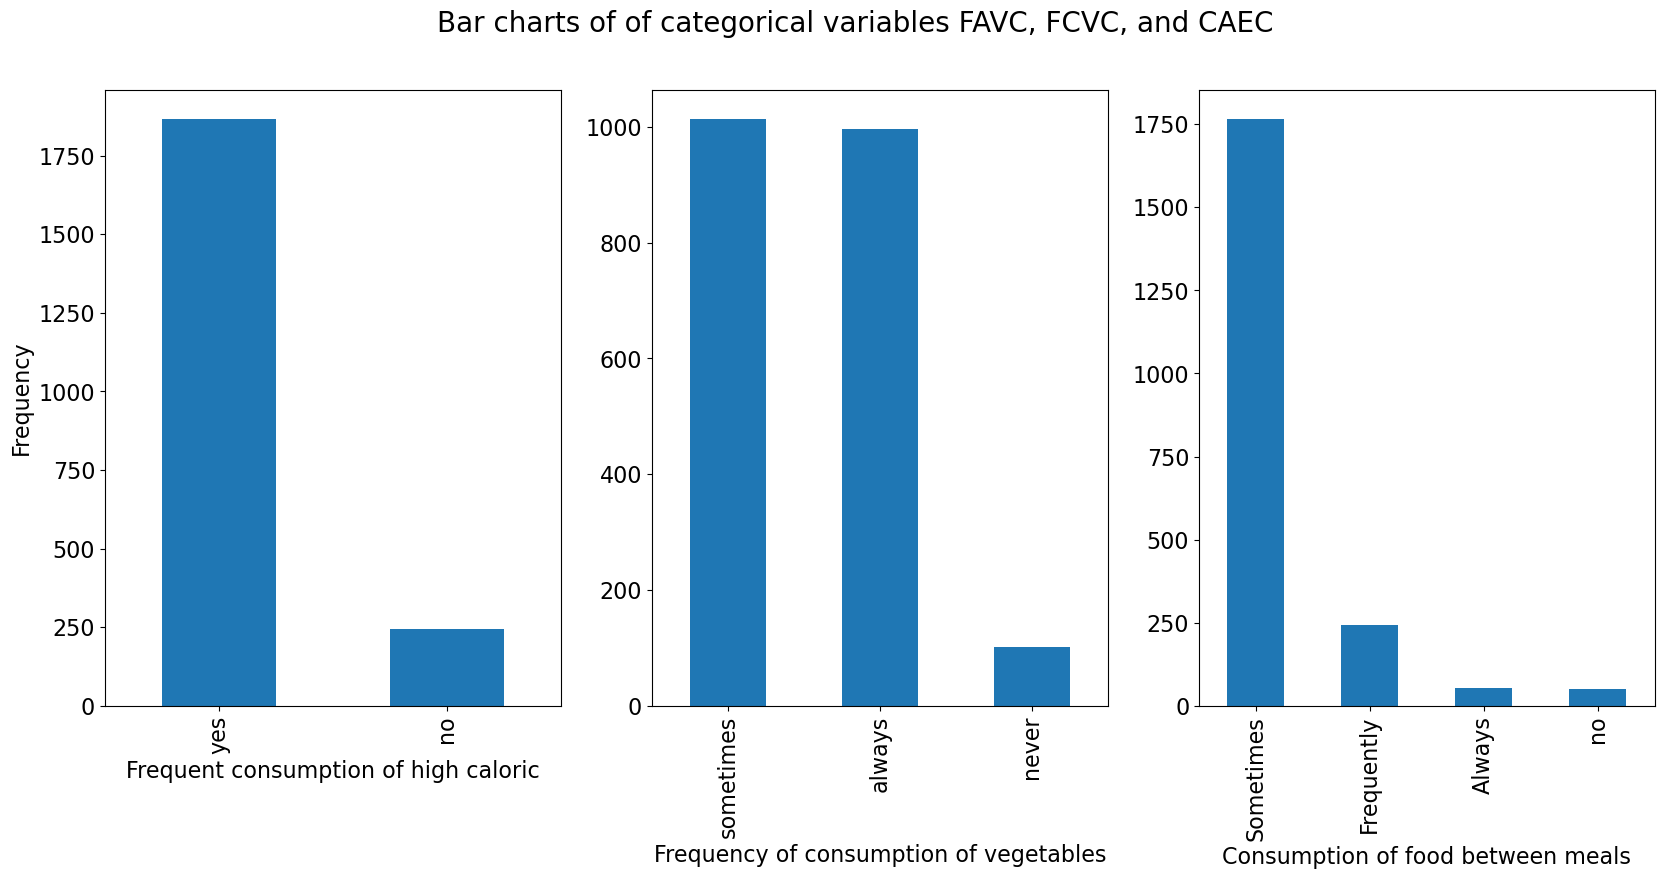

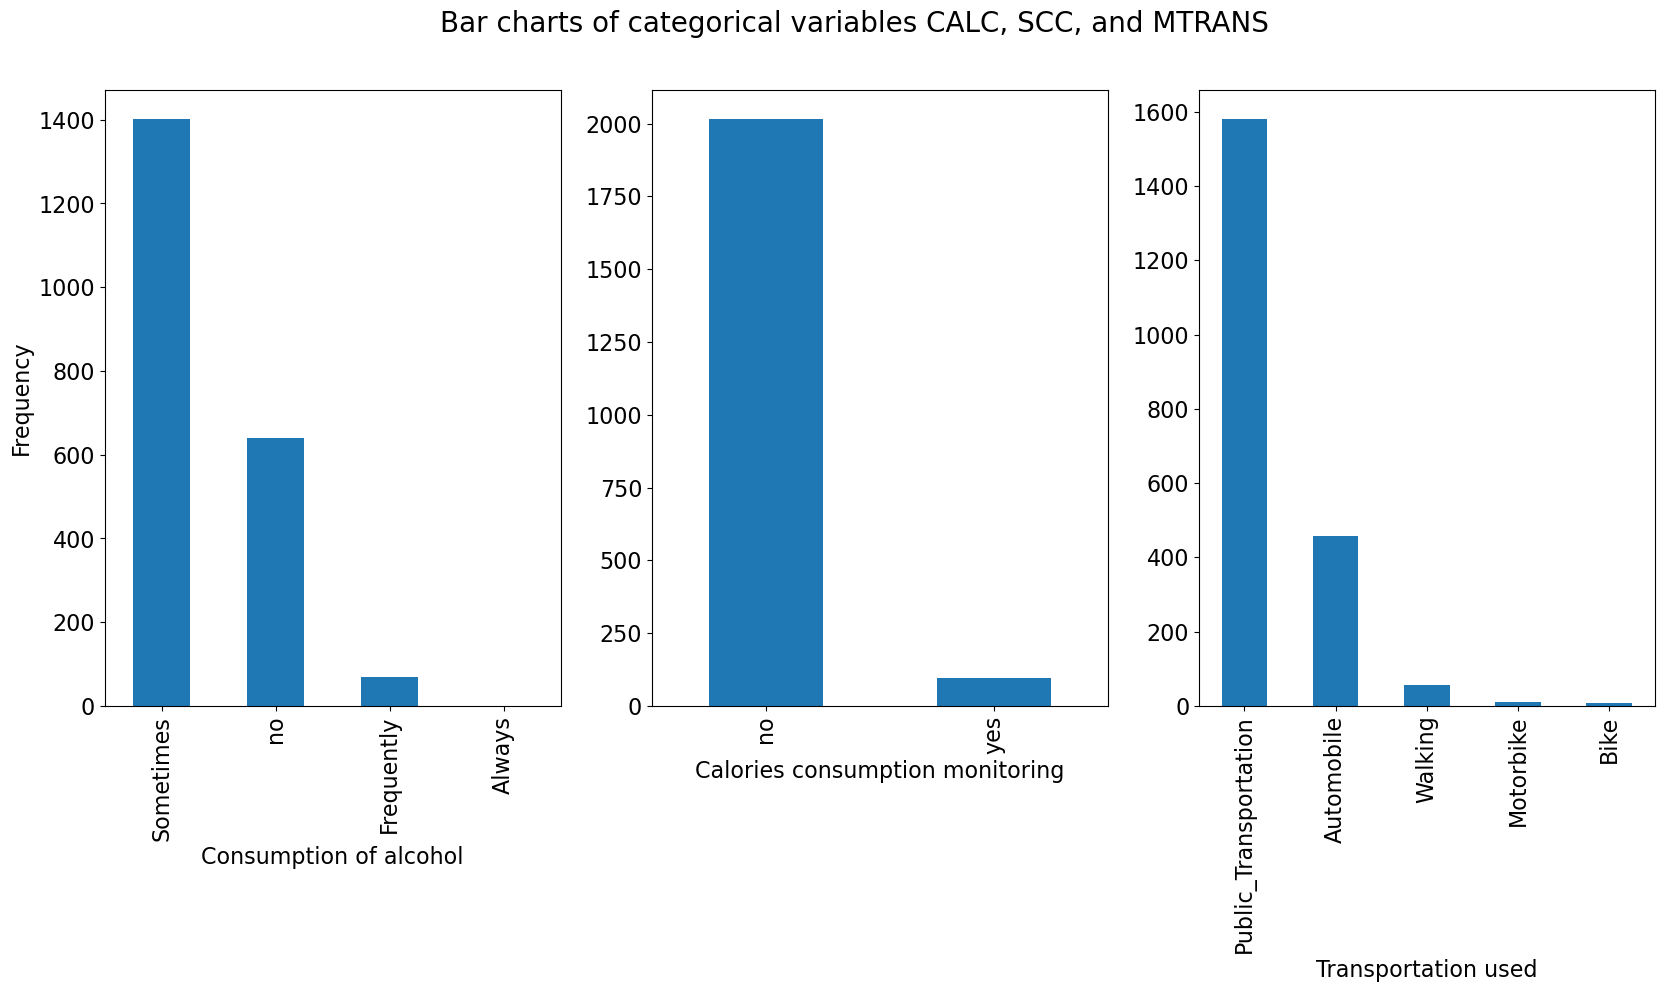

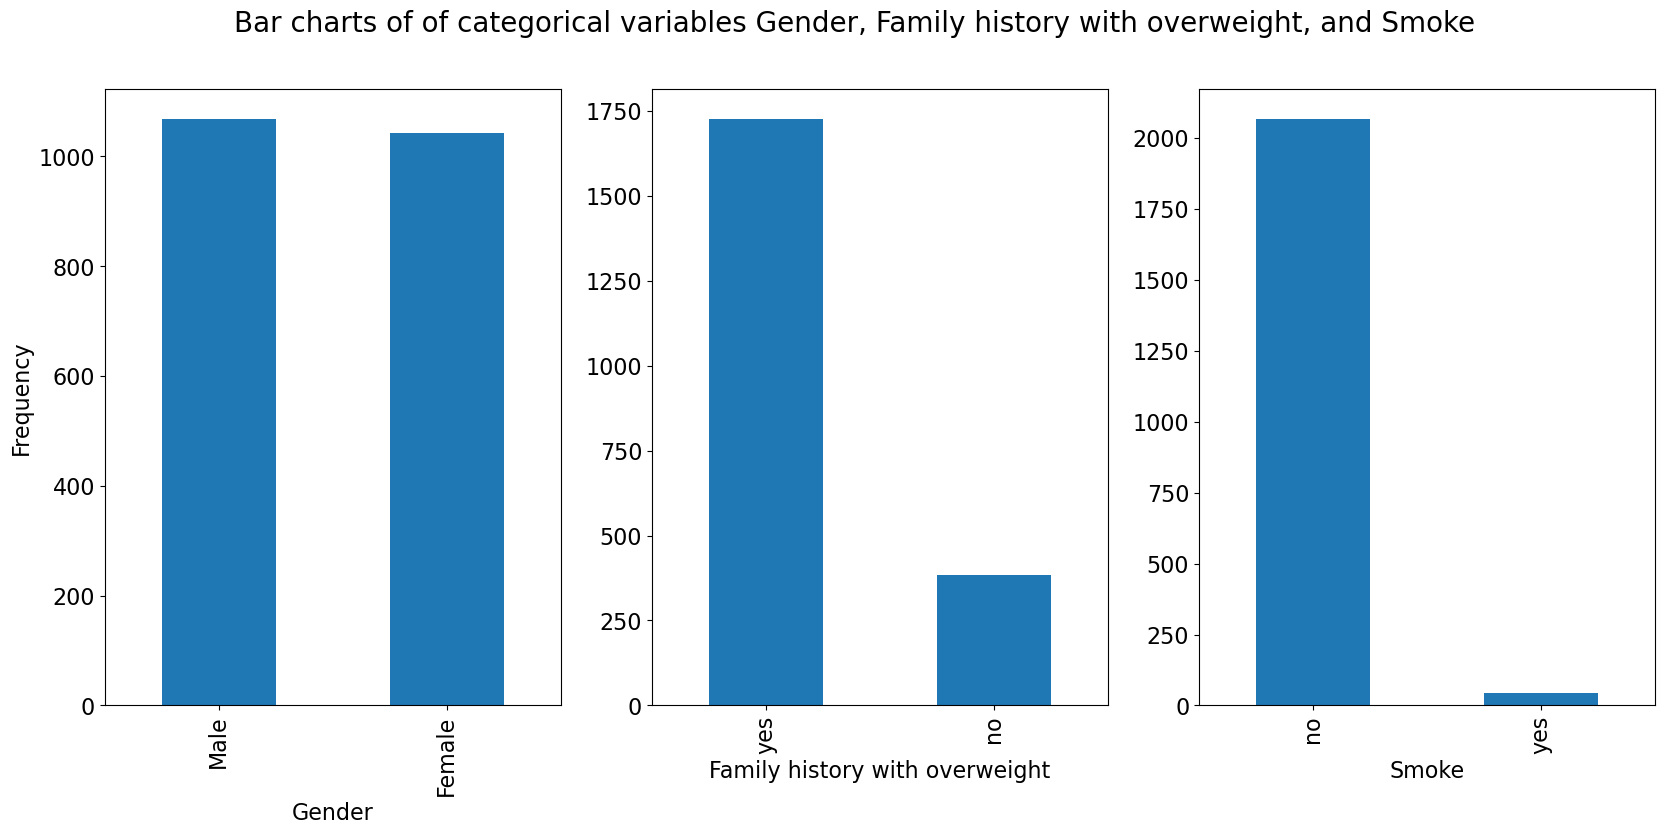

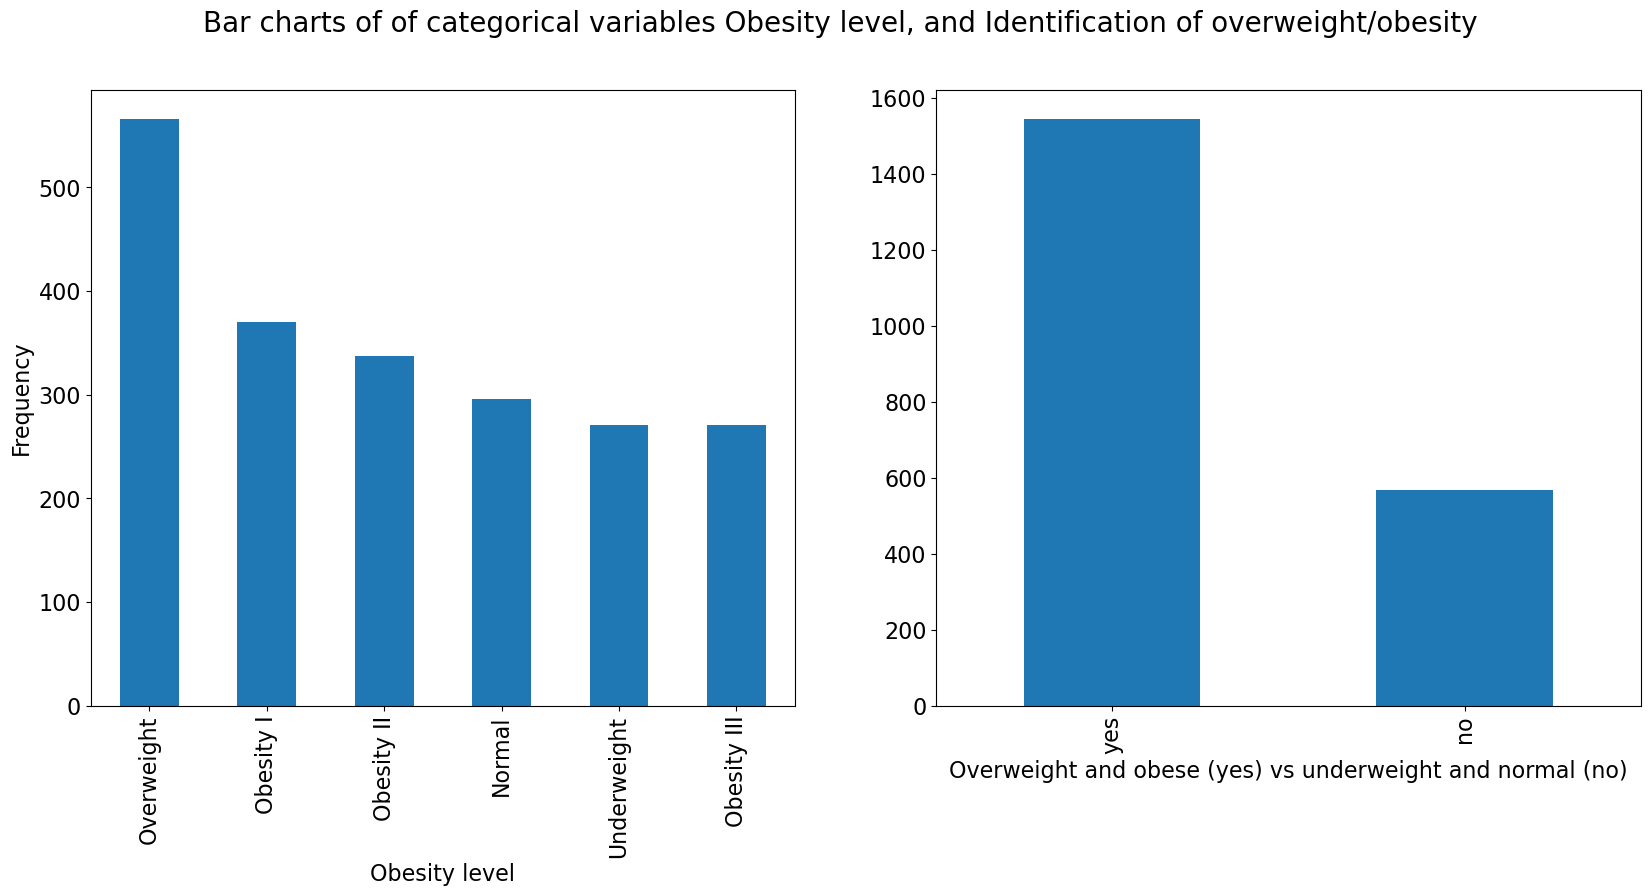

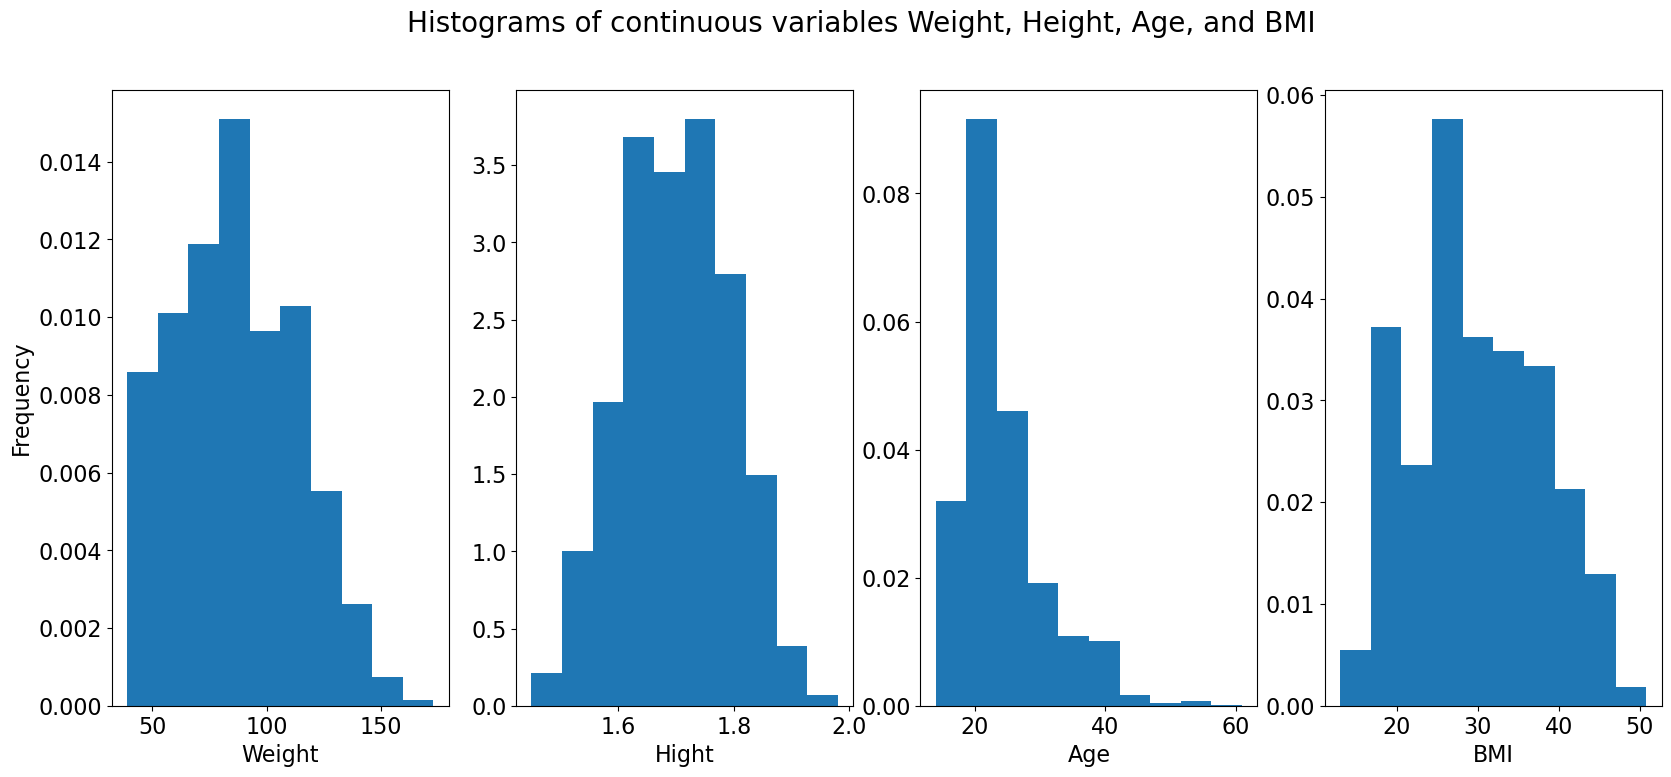

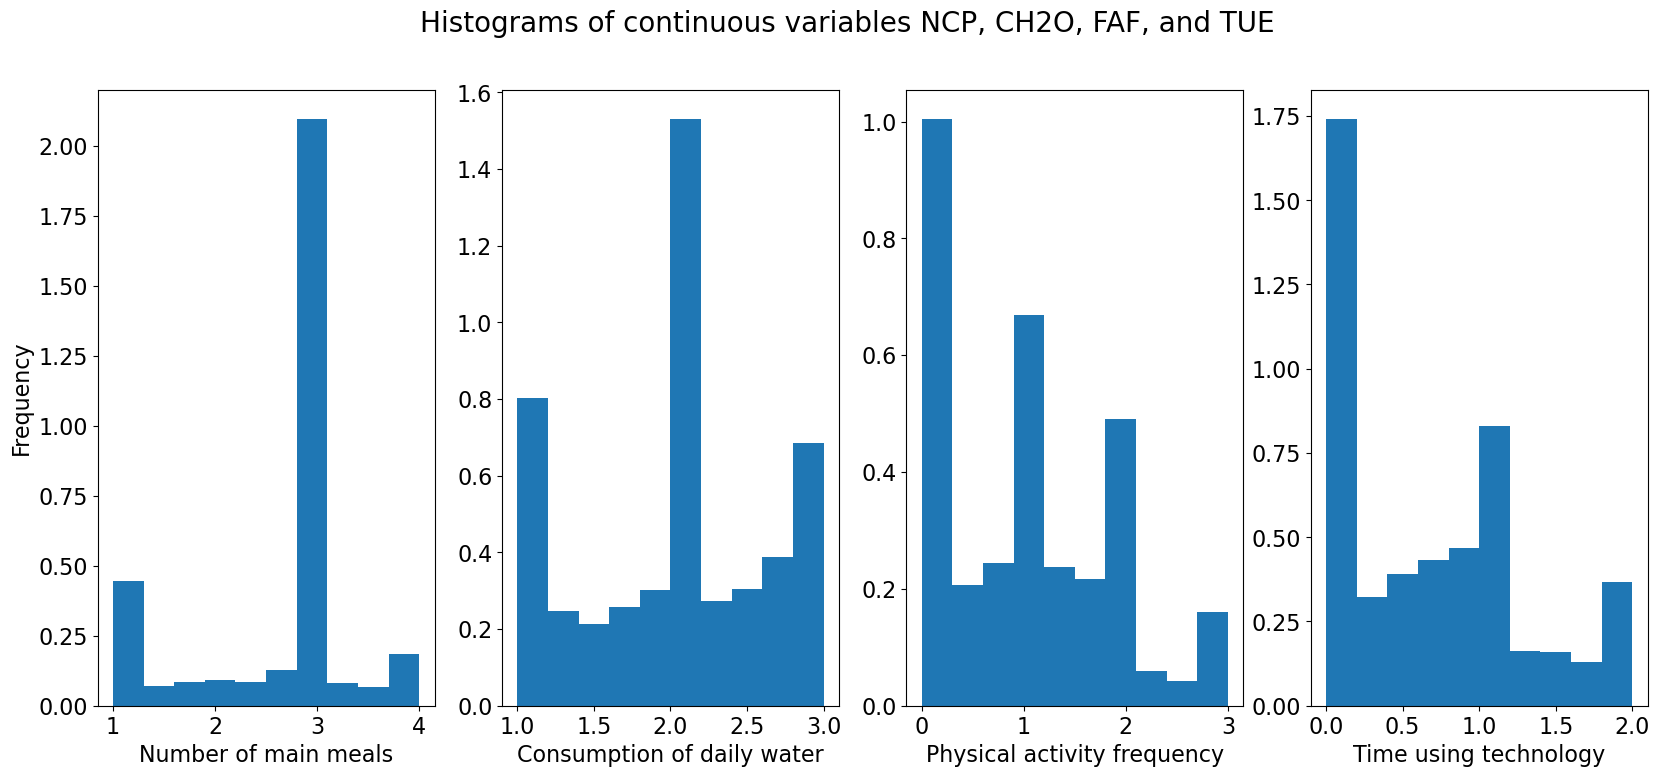

In [116]:
count_f = 0 # number of females
for jj in range(len(gender)):
    if gender[jj] == 'Female': 
        count_f = count_f + 1
count_m = len(gender) - count_f # number of males 
print('There are', count_f, 'females and', count_m, 'males.')

age_f = age.loc[dataset['Gender'] == 'Female'] # ages of females
age_m = age.loc[dataset['Gender'] == 'Male'] # ages of males
weight_f = weight.loc[dataset['Gender'] == 'Female'] # weights of females
weight_m = weight.loc[dataset['Gender'] == 'Male'] # weights of males
height_f = height.loc[dataset['Gender'] == 'Female'] # heights of females
height_m = height.loc[dataset['Gender'] == 'Male'] # heights of males
BMI_f = weight_f / np.power(height_f, 2) # BMI for females
BMI_m = weight_m / np.power(height_m, 2) # BMI for males

# Sample size, mean, standard deviation, and five number summary for age, weight, height variables for females 
summary_agef = age_f.describe() 
print('Summary age for females \n', round(summary_agef, 2))
summary_weightf = weight_f.describe() 
print('Summary weight for females \n', round(summary_weightf, 2))
summary_heightf = height_f.describe() 
print('Summary height for females \n', round(summary_heightf, 2))
summary_BMIf = BMI_f.describe() 
print('Summary BMI for females \n', round(summary_BMIf, 2))

# Sample size, mean, standard deviation, and five number summary for age, weight, height variables for males
summary_agem = age_m.describe() 
print('Summary age for males \n', round(summary_agem, 2))
summary_weightm = weight_m.describe() 
print('Summary weight for males \n', round(summary_weightm, 2))
summary_heightm = height_m.describe() 
print('Summary height for males \n', round(summary_heightm, 2))
summary_BMIm = BMI_m.describe() 
print('Summary BMI for males \n', round(summary_BMIm, 2))

# Visualization of distrubution of each variable 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,8))
plt.rcParams['font.size'] = '16'
FAVC.value_counts().plot(ax = ax1, kind = 'bar', xlabel = 'Frequent consumption of high caloric', ylabel = 'Frequency')
FCVC.value_counts().plot(ax = ax2, kind = 'bar', xlabel = 'Frequency of consumption of vegetables')
CAEC.value_counts().plot(ax = ax3, kind = 'bar', xlabel = 'Consumption of food between meals')
fig.suptitle('Bar charts of of categorical variables FAVC, FCVC, and CAEC', fontsize = 20)
plt.savefig('Fig1.jpeg', bbox_inches='tight') 
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,8))
plt.rcParams['font.size'] = '16'
CALC.value_counts().plot(ax = ax1, kind = 'bar', xlabel = 'Consumption of alcohol', ylabel = 'Frequency')
SCC.value_counts().plot(ax = ax2, kind = 'bar', xlabel = 'Calories consumption monitoring')
MTRANS.value_counts().plot(ax = ax3, kind = 'bar', xlabel = 'Transportation used')
fig.suptitle('Bar charts of categorical variables CALC, SCC, and MTRANS', fontsize = 20)
plt.savefig('Fig2.jpeg', bbox_inches='tight') 
plt.show()

# Visualization of distrubution of each variable 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,8))
plt.rcParams['font.size'] = '16'
gender.value_counts().plot(ax = ax1, kind = 'bar', xlabel = 'Gender', ylabel = 'Frequency')
family_overweight.value_counts().plot(ax = ax2, kind = 'bar', xlabel = 'Family history with overweight')
SMOKE.value_counts().plot(ax = ax3, kind = 'bar', xlabel = 'Smoke')
fig.suptitle('Bar charts of of categorical variables Gender, Family history with overweight, and Smoke', fontsize = 20)
plt.savefig('Fig3.jpeg', bbox_inches='tight') 
plt.show()

# Visualization of distrubution of each variable 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,8))
plt.rcParams['font.size'] = '16'
obesitylevel.value_counts().plot(ax = ax1, kind = 'bar', xlabel = 'Obesity level', ylabel = 'Frequency')
obesitylevel_bisbis.value_counts().plot(ax = ax2, kind = 'bar', xlabel = 'Overweight and obese (yes) vs underweight and normal (no)')
fig.suptitle('Bar charts of of categorical variables Obesity level, and Identification of overweight/obesity', fontsize = 20)
plt.savefig('Fig3.jpeg', bbox_inches='tight') 
plt.show()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20,8))
ax1.hist(weight, density = True)
ax1.set_xlabel('Weight')
ax1.set_ylabel('Frequency')
ax2.hist(height, density = True)
ax2.set_xlabel('Hight')
ax3.hist(age, density = True)
ax3.set_xlabel('Age')
ax4.hist(BMI, density = True)
ax4.set_xlabel('BMI')
fig.suptitle('Histograms of continuous variables Weight, Height, Age, and BMI', fontsize = 20)
plt.savefig('Fig5.jpeg', bbox_inches='tight') 
plt.show()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20,8))
ax1.hist(NCP, density = True)
ax1.set_xlabel('Number of main meals')
ax1.set_ylabel('Frequency')
ax2.hist(CH2O, density = True)
ax2.set_xlabel('Consumption of daily water')
ax3.hist(FAF, density = True)
ax3.set_xlabel('Physical activity frequency')
ax4.hist(TUE, density = True)
ax4.set_xlabel('Time using technology')
fig.suptitle('Histograms of continuous variables NCP, CH2O, FAF, and TUE', fontsize = 20)
plt.savefig('Fig6.jpeg', bbox_inches='tight') 
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,8))
dataset.groupby(['NObeyesdad', 'Gender']).size().unstack().plot(ax = ax1, kind = 'bar', stacked = True, xlabel = 'Obesity level', ylabel = 'Frequency', title = 'By gender')
dataset.groupby(['NObeyesdad', 'family_history_with_overweight']).size().unstack().plot(ax = ax2, kind = 'bar', stacked = True, xlabel = 'Obesity level', title = 'By family history with overweight')
dataset.groupby(['NObeyesdad', 'SMOKE']).size().unstack().plot(ax = ax3, kind = 'bar', stacked = True, xlabel = 'Obesity level', title = 'By smoke')
fig.suptitle('Relationships between obesity level and gender, family history and smoke ', fontsize = 20)
plt.savefig('Fig7.jpeg', bbox_inches='tight') 
plt.show()


## Exploratory Data Analysis (ii)

Biostatistics univariate tests are performed to evaluate the correlation between the obesity level and each eating habit and physical condition attribute. As suggested by Chicco et al., the Anderson Darling test is performed, in order to verify if continuous eating habits and physical condition attributes are normally distributed. To evaluate the associations between categorical eating habits / physical conditions attributes and obesity level (categorical), we adopt the Chi-squared test of independance, while to evaluate associations between continuous eating habits / physical conditions attributes and obesity level (categorical), we use logistic regression. Based on the p-values, we find that the most important variables are NCP, CH20, FAF, TUE, weight, hight and age. 

Reference: 

Chicco, D., & Jurman, G. (2020). Survuval prediction of patients with sepsis from age, sex, and septinc episode number alone. Scientific Report 10(1), Article 17156. https://doi.org/10.1038/s41598-020-73558-3 

In [ ]:
eating_habits_continuous = np.array([NCP, CH2O]) # continuous eating habits attributes
physical_conditions_continuous = np.array([FAF, TUE]) # countinuous physical conditions attributes
other_continuous = np.array([age, weight, height]) # other continuous attributes
lab_eating_habits_continuous = ['NCP', 'CH20'] # label continuous eating habits attributes
lab_physical_conditions_continuous = ['FAF', 'TUE'] # label continuous physical conditions attributes
lab_other_continuous = ['age', 'weight', 'height'] # label other continuous attributes

# Anderson Darling test to verify if continuous variables are normally distributed 
# Eating habits
for jj in range(len(eating_habits_continuous)):
    anderson_test = scipy.stats.anderson(eating_habits_continuous[jj])
    count_anderson = 0 
    index_anderson = 0
    significance_level_anderson = []
    for kk in range (len(anderson_test.critical_values)):
        if anderson_test.critical_values[kk] >= anderson_test.statistic:
            count_anderson = count_anderson + 1 
            significance_level_anderson[index_anderson] = kk
            index_anderson = index_anderson + 1
    if count_anderson == 0:
        print('The null hypothesis that', lab_eating_habits_continuous[jj], 'is normally distributed cannot be rejected')
    else:
        print('The null hypothesis that', lab_eating_habits_continuous[jj], 'is normally distributed may be rejected at the significance level of', round(min(index_anderson), 2))
# Physical conditions
for jj in range(len(physical_conditions_continuous)):
    anderson_test = scipy.stats.anderson(physical_conditions_continuous[jj])
    count_anderson = 0 
    index_anderson = 0
    significance_level_anderson = []
    for kk in range (len(anderson_test.critical_values)):
        if anderson_test.critical_values[kk] >= anderson_test.statistic:
            count_anderson = count_anderson + 1 
            significance_level_anderson[index_anderson] = kk
            index_anderson = index_anderson + 1
    if count_anderson == 0:
        print('The null hypothesis that', lab_physical_conditions_continuous[jj], 'is normally distributed cannot be rejected')
    else:
        print('The null hypothesis that', lab_physical_conditions_continuous[jj], 'is normally distributed may be rejected at the significance level of', round(min(index_anderson), 2))
# Other attributes
for jj in range(len(other_continuous)):
    anderson_test = scipy.stats.anderson(other_continuous[jj])
    count_anderson = 0 
    index_anderson = 0
    significance_level_anderson = []
    for kk in range (len(anderson_test.critical_values)):
        if anderson_test.critical_values[kk] >= anderson_test.statistic:
            count_anderson = count_anderson + 1 
            significance_level_anderson[index_anderson] = kk
            index_anderson = index_anderson + 1
    if count_anderson == 0:
        print('The null hypothesis that', lab_other_continuous[jj], 'is normally distributed cannot be rejected')
    else:
        print('The null hypothesis that', lab_other_continuous[jj], 'is normally distributed may be rejected at the significance level of', round(min(index_anderson), 2))
        
# Chi-squared tests of independence to evaluate the associations between categorical eating habits / physical conditions attributes and obesity level (categorical)
label_obesitylevel_bisbis = ['yes', 'no']

# FAVC and obesity level
label_FAVC = ['yes', 'no']
table_FAVC = pd.crosstab(FAVC, obesitylevel_bisbis, normalize = 'index')
table_FAVC.index = label_FAVC
table_FAVC.columns = label_obesitylevel_bisbis
# print('Contingency Table (FAVC, obesitylevel_bisbis): \n', table_FAVC)
table_FAVC = sm.stats.Table(table_FAVC)
print('\n Chi-squared test of independence (FAVC, obesitylevel_bisbis), p-value: \n', round(table_FAVC.test_nominal_association().pvalue, 3))

# FCVC and obesity level
label_FCVC = ['never', 'sometimes', 'always']
table_FCVC = pd.crosstab(FCVC, obesitylevel_bisbis, normalize = 'index')
table_FCVC.index = label_FCVC
table_FCVC.columns = label_obesitylevel_bisbis
# print('Contingency Table (FCVC, obesity_level_bisbis): \n', table_FCVC)
table_FCVC = sm.stats.Table(table_FCVC)
print('Chi-squared test of independence (FCVC, obesitylevel_bisbis), p-value: \n', round(table_FCVC.test_nominal_association().pvalue, 3))

# CAEC and obesity level
label_CAEC = ['no', 'sometimes', 'frequently', 'always']
table_CAEC = pd.crosstab(CAEC, obesitylevel_bisbis, normalize = 'index')
table_CAEC.index = label_CAEC
table_CAEC.columns = label_obesitylevel_bisbis
# print('Contingency Table (CAEC, obesitylevel_bisbis): \n', table_CAEC)
table_CAEC = sm.stats.Table(table_CAEC)
print('Chi-squared test of independence (CAEC, obesitylevel_bisbis), p-value: \n', round(table_CAEC.test_nominal_association().pvalue, 3))

# CALC and obesity level
label_CALC = ['no', 'sometimes', 'frequently', 'always']
table_CALC = pd.crosstab(CALC, obesitylevel_bisbis, normalize = 'index')
table_CALC.index = label_CALC
table_CALC.columns = label_obesitylevel_bisbis
# print('Contingency Table (CALC, obesitylevel_bisbis): \n', table_CALC)
table_CALC = sm.stats.Table(table_CALC)
print('Chi-squared test of independence (CALC, obesitylevel_bisbis), p-value: \n', round(table_CALC.test_nominal_association().pvalue, 3))

# SCC and obesity level
label_SCC = ['yes', 'no']
table_SCC = pd.crosstab(SCC, obesitylevel_bisbis, normalize = 'index')
table_SCC.index = label_SCC
table_SCC.columns = label_obesitylevel_bisbis
# print('Contingency Table (SCC, obesitylevel_bisbis): \n', table_SCC)
table_SCC = sm.stats.Table(table_SCC)
print('Chi-squared test of independence (SCC, obesitylevel_bisbis), p-value: \n', round(table_SCC.test_nominal_association().pvalue, 3))

# MTRANS and obesity level
label_MTRANS = ['automobile', 'motorbike', 'bike', 'public transport', 'walking']
table_MTRANS = pd.crosstab(MTRANS, obesitylevel_bisbis, normalize = 'index')
table_MTRANS.index = label_MTRANS
table_MTRANS.columns = label_obesitylevel_bisbis
# print('Contingency Table (MTRANS, obesitylevel_bisbis): \n', table_MTRANS)
table_MTRANS = sm.stats.Table(table_MTRANS)
print('Chi-squared test of independence (MTRANS, obesitylevel_bisbis), p-value: \n', round(table_MTRANS.test_nominal_association().pvalue, 3))

# family_overweight and obesity level
label_family_overweight = ['yes', 'no']
table_family_overweight = pd.crosstab(family_overweight, obesitylevel_bisbis, normalize = 'index')
table_family_overweight.index = label_family_overweight
table_family_overweight.columns = label_obesitylevel_bisbis
# print('Contingency Table (family_overweight, obesitylevel_bisbis): \n', table_family_overweight)
table_family_overweight = sm.stats.Table(table_family_overweight)
print('Chi-squared test of independence (family_overweight, obesitylevel_bisbis), p-value: \n', round(table_family_overweight.test_nominal_association().pvalue, 3))

# SMOKE and obesity level
label_SMOKE = ['yes', 'no']
table_SMOKE = pd.crosstab(SMOKE, obesitylevel_bisbis, normalize = 'index')
table_SMOKE.index = label_SMOKE
table_SMOKE.columns = label_obesitylevel_bisbis
# print('Contingency Table (SMOKE, obesitylevel_bisbis): \n', table_SMOKE)
table_SMOKE = sm.stats.Table(table_SMOKE)
print('Chi-squared test of independence (SMOKE, obesitylevel_bisbis), p-value: \n', round(table_SMOKE.test_nominal_association().pvalue, 3))

# gender and obesity level
label_gender = ['Female', 'Male']
table_gender = pd.crosstab(gender, obesitylevel_bisbis, normalize = 'index')
table_gender.index = label_gender
table_gender.columns = label_obesitylevel_bisbis
# print('Contingency Table (gender, obesitylevel_bisbis): \n', table_gender)
table_gender = sm.stats.Table(table_gender)
print('Chi-squared test of independence (gender, obesitylevel_bisbis), p-value: \n', round(table_gender.test_nominal_association().pvalue, 3))

# Logistic regression to evaluate the associations between continuous eating habits / physical conditions attributes and obesity level (categorical)

# NCP and obesity level 
data_NCP_obesity = pd.DataFrame(data = {'obesitylevel_bis': obesitylevel_bis, 'NCP': NCP})
fit_NCP = smf.glm('obesitylevel_bis ~ NCP', family = sm.families.Binomial(), data = data_NCP_obesity).fit()
print('\n Generalized linear model regression results (NCP, obesitylevel_bis): \n', fit_NCP.pvalues)

# CH20 and obesity level 
data_CH20_obesity = pd.DataFrame(data = {'obesitylevel_bis': obesitylevel_bis, 'CH20': CH2O})
fit_CH20 = smf.glm('obesitylevel_bis ~ CH20', family = sm.families.Binomial(), data = data_CH20_obesity).fit()
print('Generalized linear model regression results (CH20, obesitylevel_bis): \n', fit_CH20.pvalues)

# FAF and obesity level 
data_FAF_obesity = pd.DataFrame(data = {'obesitylevel_bis': obesitylevel_bis, 'FAF': FAF})
fit_FAF = smf.glm('obesitylevel_bis ~ FAF', family = sm.families.Binomial(), data = data_FAF_obesity).fit()
print('Generalized linear model regression results (FAF, obesitylevel_bis): \n', fit_FAF.pvalues)

# TUE and obesity level 
data_TUE_obesity = pd.DataFrame(data = {'obesitylevel_bis': obesitylevel_bis, 'TUE': TUE})
fit_TUE = smf.glm('obesitylevel_bis ~ TUE', family = sm.families.Binomial(), data = data_TUE_obesity).fit()
print('Generalized linear model regression results (TUE, obesitylevel_bis): \n', fit_TUE.pvalues)

# age and obesity level 
data_age_obesity = pd.DataFrame(data = {'obesitylevel_bis': obesitylevel_bis, 'age': age})
fit_age = smf.glm('obesitylevel_bis ~ age', family = sm.families.Binomial(), data = data_age_obesity).fit()
print('Generalized linear model regression results (age, obesitylevel_bis): \n', fit_age.pvalues)

# weight and obesity level 
data_weight_obesity = pd.DataFrame(data = {'obesitylevel_bis': obesitylevel_bis, 'weight': weight})
fit_weight = smf.glm('obesitylevel_bis ~ weight', family = sm.families.Binomial(), data = data_weight_obesity).fit()
print('Generalized linear model regression results (weight, obesitylevel_bis): \n', fit_weight.pvalues)

# height and obesity level 
data_height_obesity = pd.DataFrame(data = {'obesitylevel_bis': obesitylevel_bis, 'height': height})
fit_height = smf.glm('obesitylevel_bis ~ height', family = sm.families.Binomial(), data = data_height_obesity).fit()
print('Generalized linear model regression results (height, obesitylevel_bis): \n', fit_height.pvalues)

The null hypothesis that NCP is normally distributed cannot be rejected
The null hypothesis that CH20 is normally distributed cannot be rejected
The null hypothesis that FAF is normally distributed cannot be rejected
The null hypothesis that TUE is normally distributed cannot be rejected
The null hypothesis that age is normally distributed cannot be rejected
The null hypothesis that weight is normally distributed cannot be rejected
The null hypothesis that height is normally distributed cannot be rejected

 Chi-squared test of independence (FAVC, obesitylevel_bisbis), p-value: 
 0.666
Chi-squared test of independence (FCVC, obesitylevel_bisbis), p-value: 
 0.969
Chi-squared test of independence (CAEC, obesitylevel_bisbis), p-value: 
 0.74
Chi-squared test of independence (CALC, obesitylevel_bisbis), p-value: 
 0.888
Chi-squared test of independence (SCC, obesitylevel_bisbis), p-value: 
 0.615
Chi-squared test of independence (MTRANS, obesitylevel_bisbis), p-value: 
 0.953
Chi-squared t

## Model Selection

We tested two different models, the logistic regression model with binary data and the ordered logistic regression model. For each model, two different cases are explored. CASE 1 uses all important dependent variables apart from weight and height, while CASE 2 uses all important dependent variables apart from weight. 

In [ ]:
# MODEL 1: logistic regression model with binary data, with all important variables indentified with EDA, apart from weight and height in CASE 1, and just weight in CASE 2 
# CASE 1: weight and height are excluded
data_model1_case1 = pd.DataFrame(data = {'age': age, 'NCP': NCP, 'CH20': CH2O, 'FAF': FAF, 'TUE': TUE, 'obesitylevel_bisbis': obesitylevel_bisbis}) # data for MODEL 1, CASE 1
model1_case1 = smf.glm('obesitylevel_bisbis ~ age + NCP + CH20 + FAF + TUE', family = sm.families.Binomial(), data = data_model1_case1)
result1_case1 = model1_case1.fit()
print('Logistic regression with a binary dependent variable, with weight and hight excluded from important independent variables: \n', result1_case1.summary())

# CASE 2: weight is excluded
data_model1_case2 = pd.DataFrame(data = {'height': height, 'age': age, 'NCP': NCP, 'CH20': CH2O, 'FAF': FAF, 'TUE': TUE, 'obesitylevel_bisbis': obesitylevel_bisbis}) # data for MODEL 1, CASE 2
model1_case2 = smf.glm('obesitylevel_bisbis ~ height + age + NCP + CH20 + FAF + TUE', family = sm.families.Binomial(), data = data_model1_case2)
result1_case2 = model1_case2.fit()
print('Logistic regression with a binary response variable, with weight excluded from important independent variables: \n', result1_case2.summary())

# MODEL 2: ordered logistic regression model, with all important variables indentified with EDA, apart from weight and height in CASE 1, and just weight in CASE 2 

obesitylevel_type = CategoricalDtype(categories = ['Underweight', 'Normal', 'Overweight', 'Obesity I', 'Obesity II', 'Obesity III'], ordered = True)
obesitylevel_var = obesitylevel.astype(obesitylevel_type)

# CASE 1: weight and height are excluded
data_model2_case1 = pd.DataFrame(data = {'age': age, 'NCP': NCP, 'CH20': CH2O, 'FAF': FAF, 'TUE': TUE, 'obesitylevel_var': obesitylevel_var}) # data for MODEL 2, CASE 1
model2_case1 = OrderedModel(data_model2_case1['obesitylevel_var'], data_model2_case1[['age', 'NCP', 'CH20', 'FAF', 'TUE']], distr = 'logit')
result2_case1 = model2_case1.fit(method = 'bfgs')
print('Ordered logistic regression with an ordinal response variable, with weight and hight excluded from important independent variables: \n', result2_case1.summary())

# CASE 2: weight is excluded
data_model2_case2 = pd.DataFrame(data = {'height': height, 'age': age, 'NCP': NCP, 'CH20': CH2O, 'FAF': FAF, 'TUE': TUE, 'obesitylevel_var': obesitylevel_var}) # data for MODEL 2, CASE 1
model2_case2 = OrderedModel(data_model2_case2['obesitylevel_var'], data_model2_case2[['height', 'age', 'NCP', 'CH20', 'FAF', 'TUE']], distr = 'logit')
result2_case2 = model2_case2.fit(method = 'bfgs')
print('Ordered logistic regression with an ordinal response variable, with weight excluded from important independent variables: \n', result2_case2.summary())


Logistic regression with a binary dependent variable, with weight and hight excluded from important independent variables: 
                                     Generalized Linear Model Regression Results                                    
Dep. Variable:     ['obesitylevel_bisbis[no]', 'obesitylevel_bisbis[yes]']   No. Observations:                 2111
Model:                                                                 GLM   Df Residuals:                     2105
Model Family:                                                     Binomial   Df Model:                            5
Link Function:                                                       Logit   Scale:                          1.0000
Method:                                                               IRLS   Log-Likelihood:                -1006.2
Date:                                                     Sun, 26 Feb 2023   Deviance:                       2012.4
Time:                                                          

   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        

/Users/caterinagallo/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/caterinagallo/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


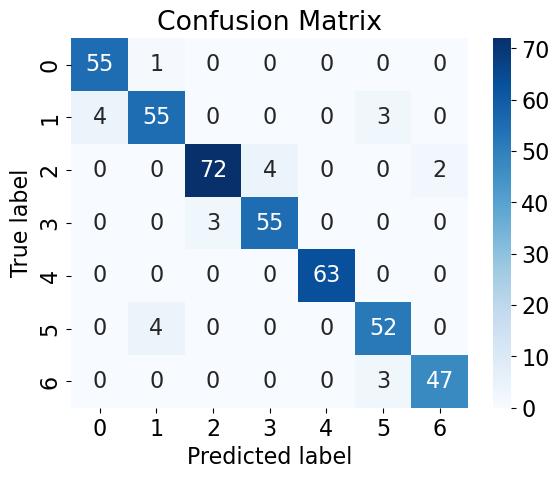

In [ ]:
#BLOCK 7 STARTS
"""
Decision tree for this dataset - Including all variables
"""

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')

#print(df.head())

# Define the target variable and input features
y = df['NObeyesdad']
#X = df.drop(['NObeyesdad', 'Weight', 'Height'], axis=1)
X = df.drop('NObeyesdad', axis=1)
print(df.head())

# One-hot encode categorical variables
cat_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
enc = OneHotEncoder(sparse=False, drop='first')
X_cat = enc.fit_transform(X[cat_cols])
X_num = X.drop(cat_cols, axis=1)
X = pd.concat([pd.DataFrame(X_cat), X_num], axis=1)

# Split the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the decision tree model
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

# Predict the target variable on the testing set
y_pred = dtc.predict(X_test)

# Evaluate the performance of the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion matrix:', confusion_matrix(y_test, y_pred))
print('Classification report:', classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues")

# add axis labels and title
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")

# show plot
plt.show()

#BLOCK 7 ENDS

/Users/caterinagallo/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/caterinagallo/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Accuracy: 0.7683215130023641
Confusion matrix: [[48  5  0  0  1  1  1]
 [ 2 38  5  1  1  8  7]
 [ 1  4 57  2  0  6  8]
 [ 1  0  1 53  0  2  1]
 [ 0  0  0  0 63  0  0]
 [ 2  8  6  0  0 33  7]
 [ 1  1  5  5  0  5 33]]
Classification report:                      precision    recall  f1-score   support

Insufficient_Weight       0.87      0.86      0.86        56
      Normal_Weight       0.68      0.61      0.64        62
     Obesity_Type_I       0.77      0.73      0.75        78
    Obesity_Type_II       0.87      0.91      0.89        58
   Obesity_Type_III       0.97      1.00      0.98        63
 Overweight_Level_I       0.60      0.59      0.59        56
Overweight_Level_II       0.58      0.66      0.62        50

           accuracy                           0.77       423
          macro avg       0.76      0.77      0.76       423
       weighted avg       0.77      0.77      0.77       423



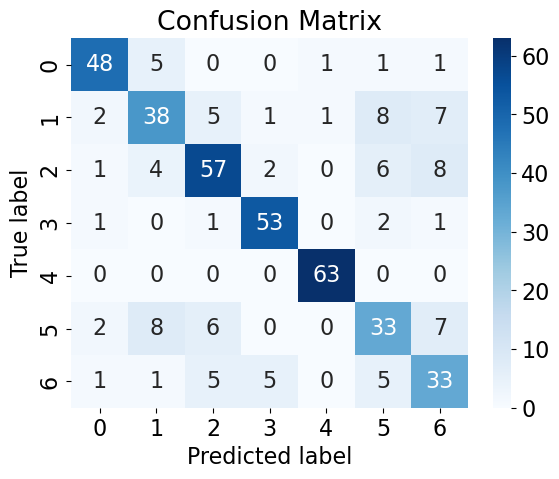

In [ ]:
#BLOCK 9 STARTS
"""
Decision tree for this dataset - Additionally, excluding weight
"""

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')

# Define the target variable and input features
y = df['NObeyesdad']
X = df.drop(['NObeyesdad', 'Weight'], axis=1)
#X = df.drop('NObeyesdad', axis=1)
#print(df.head())

# One-hot encode categorical variables
cat_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
enc = OneHotEncoder(sparse=False, drop='first')
X_cat = enc.fit_transform(X[cat_cols])
X_num = X.drop(cat_cols, axis=1)
X = pd.concat([pd.DataFrame(X_cat), X_num], axis=1)

# Split the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the decision tree model
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

# Predict the target variable on the testing set
y_pred = dtc.predict(X_test)

# Evaluate the performance of the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion matrix:', confusion_matrix(y_test, y_pred))
print('Classification report:', classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues")

# add axis labels and title
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")

# show plot
plt.show()
#BLOCK 9 ENDS

## Model Analysis 